In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
import matplotlib.pyplot as plt
from src.ortools_solver import CVRP_solver
from src.utils import distance_calculator, calculate_distance_matrix, show_matrix, print_command, calculate_num_rows
import pygmtools as pygm

/home/yq-mew/yq/chem1906/Projects/pipette_scheduling


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
def calculate_S_E(a, P=None):
    # a the jobs matrix, row is the source, column is the destination
    if P is not None:
        a = np.dot(a, P)
    a[a>0] = 1
    jobs = np.argwhere(a)
    starting_point = np.zeros((jobs.shape[0], a.shape[0]))
    ending_point = np.zeros((jobs.shape[0], a.shape[1]))
    ending_map = dict(np.argwhere(P if P is not None else np.eye(96)).tolist())
    new_jobs = []
    for i in range(jobs.shape[0]):
        starting_point[i, jobs[i, 0]] = 1
        ending_point[i, ending_map[jobs[i, 1]]] = 1
        new_jobs.append([jobs[i, 0], ending_map[jobs[i, 1]]])
    if P is None:
        return starting_point, ending_point
    else:
        return starting_point, ending_point, np.array(new_jobs)

def calculate_D_prime(D_S, D_D, S, E):
    # calculate D' = S(D_S)S^T + E(D_D)E^T
    D_prime = np.dot(np.dot(S, D_S), S.T) + np.dot(np.dot(E, D_D), E.T)
    return D_prime

def add_depot(D_prime):
    # add a depot to D'
    D_prime = np.vstack((np.zeros(D_prime.shape[0]), D_prime))
    D_prime = np.hstack((np.zeros((D_prime.shape[0], 1)), D_prime))
    return D_prime

def get_optimized_sequence(recorder):
    # get the optimized sequences from the VCRP solver, pad with -1 and sort
    for i in range(len(recorder)):
        recorder[i] = np.array(recorder[i])
        recorder[i] = np.pad(recorder[i], (0, 8-recorder[i].shape[0]), 'constant', constant_values=-1)
    # move the elements containing -1 to the end
    optimized_seuqnece = np.array(recorder)
    optimized_seuqnece = np.array(sorted(optimized_seuqnece, key=lambda x: np.sum(x!=-1)))
    optimized_seuqneces = np.array(optimized_seuqnece[::-1])
    return optimized_seuqneces

def calculate_T(sequences):
    # the matrix should be paddled with -1, return a n*n matrix
    # sequences is a n*8 matrix

    sequences_flat = sequences.flatten()
    sequences_flat = sequences_flat[sequences_flat != -1]
    zeros = np.zeros((sequences_flat.shape[0],sequences_flat.shape[0]))
    for sequence in sequences:
        for i in range(sequence.shape[0]-1):
            if sequence[i] != -1 and sequence[i+1] != -1:
                zeros[sequence[i]-1,sequence[i+1]-1] = 1
            else:
                break
    return zeros

In [3]:
def calculate_D(labware:int):
    num_rows = calculate_num_rows(labware)
    D = np.ones((labware,labware))
    for i in range(labware):
        for j in range(labware):
            if i//num_rows == j//num_rows:
                if i-j == -1:
                    D[i, j] = 0
    return D

In [23]:
def CVRP_QAP(task_matrix, iteration=5, inner_cvrp_timewall=2, final_cvrp_timewall=10, ipfp_maxiter=50):
    task_matrix[task_matrix>0] = 1
    jobs = np.argwhere(task_matrix)
    D_S = calculate_D(task_matrix.shape[0])
    D_D = calculate_D(task_matrix.shape[1])   

    output_P = np.eye(task_matrix.shape[1])
    S, E = calculate_S_E(task_matrix)
    D_prime = calculate_D_prime(D_S,D_D, S, E)
    best_cost = float('inf')
    for i in range(iteration):
        # construct & update CVRP
        D_prime = np.vstack((np.zeros(D_prime.shape[0]), D_prime))
        D_prime = np.hstack((np.zeros((D_prime.shape[0], 1)), D_prime))

        # solve CVRP
        optimized_distance, recorder = CVRP_solver(D_prime.astype(np.int64), solving_time=inner_cvrp_timewall)

        optimized_seuqnecess = get_optimized_sequence(recorder)
        t = calculate_T(optimized_seuqnecess)
        D_prime = D_prime[1:, 1:]
        # cost = trace (T^T * D_prime)
        cost = np.trace(np.dot(t.T, D_prime))
        print(f'iter={i}, cost={cost} after CVRP')
        if best_cost > cost:
            best_cost = cost
            best_output_P = output_P

        # construct QAP
        A = np.dot(np.dot(E.T, t.T), E)
        B = D_D
        K = np.kron(1-B, A.T) # transform minimization into maximization

        # solve QAP
        P = pygm.ipfp((K + K.T), n1=task_matrix.shape[1], n2=task_matrix.shape[1], x0=np.eye(task_matrix.shape[1])[None,:,:], max_iter=ipfp_maxiter)

        # new_E = E * P
        new_E = np.dot(E, P)
        new_D_prime = calculate_D_prime(D_S,D_D, S, new_E)
        cost = np.trace(np.dot(t.T, new_D_prime))
        output_P = np.dot(output_P, P)
        print(f'iter={i}, cost={cost} after QAP')
        if best_cost > cost:
            best_cost = cost
            best_output_P = output_P

        # update params
        D_prime = new_D_prime
        E = new_E

    # calculate best CVRP result with more solving time
    S, E, new_jobs = calculate_S_E(task_matrix, best_output_P)
    D_prime = calculate_D_prime(D_S,D_D, S, E)
    D_prime = np.vstack((np.zeros(D_prime.shape[0]), D_prime))
    D_prime = np.hstack((np.zeros((D_prime.shape[0], 1)), D_prime))
    best_cost, best_recorder = CVRP_solver(D_prime.astype(np.int64), solving_time=final_cvrp_timewall)
    print(f'solution cost={best_cost}')

    # transform to job id sequence
    best_recorder = get_optimized_sequence(best_recorder)

    return best_cost, best_output_P, new_jobs, best_recorder

In [24]:
def random_choice(total_elements, chosen_elements):
    '''
    total_elements: total number of elements in the array
    chosen_elements: number of elements to be chosen
    '''
    a = np.zeros(total_elements)
    random_vector = np.random.rand(chosen_elements)
    random_vector = random_vector.round(2)
    random_vector = random_vector / random_vector.sum(axis=0, keepdims=1)
    a[:chosen_elements] = random_vector
    np.random.shuffle(a)
    return a

def random_choose_candidate(source_dim,dest_dim,non_zeros_dim): 
    '''
    num_candidate: number of candidate to be chosen
    total_candidate: total number of candidates
    chosen_elements: number of elements to be chosen
    '''
    # repeat the random_choice function for num_candidate times
    a = np.zeros((source_dim,dest_dim))
    for i in range(source_dim):
        candidate = random_choice(dest_dim,non_zeros_dim)
        a[i,:] = candidate
    return a.round(2)

In [ ]:
stat = []
for i in range(1,10):
    experiments = random_choose_candidate(96,384,i)
    jobs = np.argwhere(experiments)
    distance_matrix = calculate_distance_matrix(jobs,experiments.shape[0],experiments.shape[1])
    optimized_distance, _, new_jobs, recorder= CVRP_QAP(experiments,iteration=5)
    VRP_distance, _ = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(jobs)
    stat.append((i,non_optimized_distance,optimized_distance, VRP_distance))
stat = np.array(stat)

KeyError: np.int64(184)

In [12]:
# generate the random addition matrix
# row is the source, column is the destination
a = random_choose_candidate(96,24,4)
# randomly shuffle the rows
#np.random.shuffle(a)
# binarize the matrix as 0 and 1
a[a>0] = 1
jobs = np.argwhere(a)

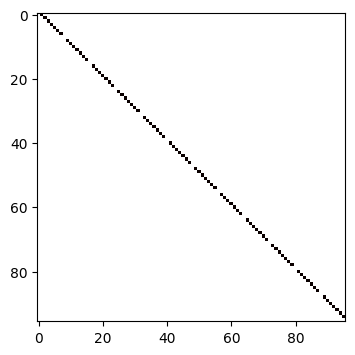

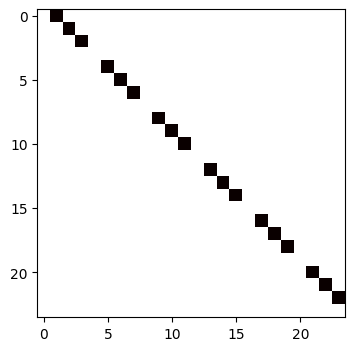

In [13]:
D_S = calculate_D(96)
D_D = calculate_D(24)
show_matrix(D_S)
show_matrix(D_D)

In [14]:
S, E = calculate_S_E(a)
D_prime = calculate_D_prime(D_S,D_D, S, E)
D_prime = np.vstack((np.zeros(D_prime.shape[0]), D_prime))
D_prime = np.hstack((np.zeros((D_prime.shape[0], 1)), D_prime))

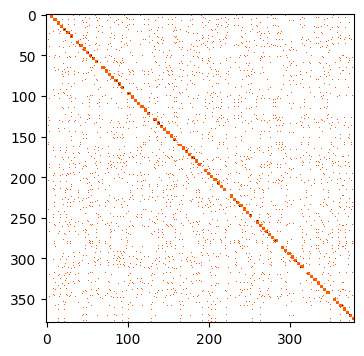

In [17]:
show_matrix(D_prime)

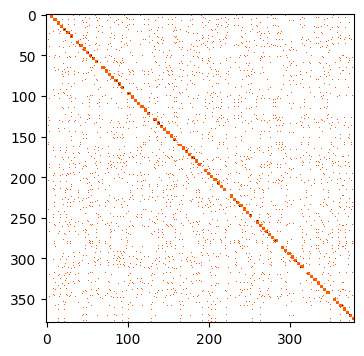

In [15]:
real_D = calculate_distance_matrix(jobs,96,24)
show_matrix(real_D)

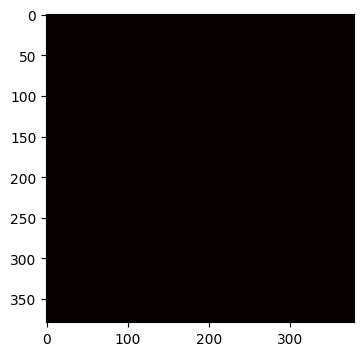

In [18]:
show_matrix(D_prime - real_D)

In [ ]:
# generate the non-symmetric matrix
# devide a 96*96 matrix into 12*12 8*8 matrix
# randomly choose n matrix to add a diagonal matrix
a = np.zeros((96,24))
# randomly pick n number from 0 to 144
picked_submatrix = np.random.choice(144, 56, replace=False)
n = 0
for i in range(12):
    for j in range(12):
        if n in picked_submatrix:
            a[i*8:(i+1)*8, j*8:(j+1)*8] = np.eye(8)
        n += 1
show_matrix(a)

ValueError: could not broadcast input array from shape (8,8) into shape (8,4)

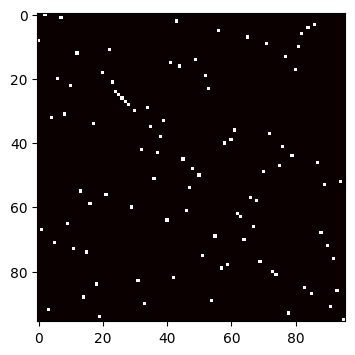

In [7]:
column_permutation = np.eye(96)
# Function to swap two columns in a matrix
def swap_columns(matrix, col1, col2):
    matrix[:, [col1, col2]] = matrix[:, [col2, col1]]

# pick an integer from 0 to 10 with gaussian distribution
for i in range(20):
    num_permutation = np.random.normal(5, 2)
    num_permutation = int(num_permutation)
    # randomly swipe two columns n times
    for j in range(num_permutation):
        exchange_columns = np.random.choice(96, 2, replace=False)
        swap_columns(column_permutation, exchange_columns[0], exchange_columns[1])
show_matrix(column_permutation)

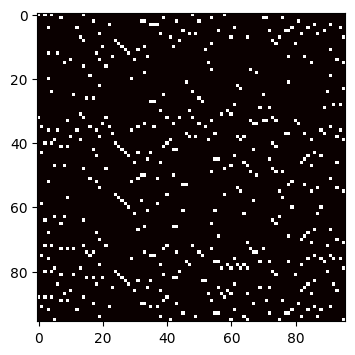

In [8]:
a = np.dot(a, column_permutation)
show_matrix(a)

In [9]:
# generate the job pair
jobs = np.argwhere(a)
volume = [a[i,j] for i,j in jobs]
volume = np.array(volume)
#distance_matrix = calculate_distance_matrix(jobs)
#S,E = calculate_S_E(jobs)
#D_prime = calculate_D_prime(D, S, E)

In [10]:
test_cost, test_P, new_jobs, test_seq = CVRP_QAP(jobs, iteration=5)

iter=0, cost=401.0 after CVRP


/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: divide by zero encountered in divide
  t0 = - alpha / beta
/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:309: RuntimeWarning: invalid value encountered in multiply
  v = np.where(np.logical_or(beta >= 0, t0 >= 1), binary_v, v + t0 * (binary_v - v))
/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/pygmtools/numpy_backend.py:308: RuntimeWarning: invalid value encountered in divide
  t0 = - alpha / beta


iter=0, cost=397.0 after QAP
iter=1, cost=387.0 after CVRP
iter=1, cost=385.0 after QAP
iter=2, cost=388.0 after CVRP
iter=2, cost=388.0 after QAP
iter=3, cost=388.0 after CVRP
iter=3, cost=388.0 after QAP
iter=4, cost=388.0 after CVRP
iter=4, cost=388.0 after QAP
solution cost=388


In [11]:
distance_matrix = calculate_distance_matrix(new_jobs)
VRP_distance, VRP_recorder = CVRP_solver(distance_matrix)
recorder = get_optimized_sequence(VRP_recorder)

In [12]:
sequence = recorder.flatten()
sequence = sequence[sequence!=-1] -1
command_line = print_command(sequence, new_jobs)
np.savetxt('optimized_command_line.csv',command_line,fmt='%s',delimiter=',')

In [13]:
jobs = np.argwhere(a)
unoptimized_command_line = print_command(np.array(range(jobs.shape[0])),jobs)
np.savetxt('unoptimized_command_line.csv',unoptimized_command_line,fmt='%s',delimiter=',')

In [14]:
stat = []
for i in range(1,20):
    experiments = random_choose_candidate(96,96,i)
    jobs = np.argwhere(experiments)
    distance_matrix = calculate_distance_matrix(jobs)
    optimized_distance, _, new_jobs, recorder= CVRP_QAP(jobs,iteration=20)
    VRP_distance, _ = CVRP_solver(distance_matrix)
    non_optimized_distance = distance_calculator(jobs)
    stat.append((i,non_optimized_distance,optimized_distance, VRP_distance))
stat = np.array(stat)

iter=0, cost=88.0 after CVRP
iter=0, cost=88.0 after QAP
iter=1, cost=80.0 after CVRP
iter=1, cost=71.0 after QAP
iter=2, cost=66.0 after CVRP
iter=2, cost=61.0 after QAP
iter=3, cost=60.0 after CVRP
iter=3, cost=58.0 after QAP
iter=4, cost=61.0 after CVRP
iter=4, cost=58.0 after QAP
iter=5, cost=60.0 after CVRP
iter=5, cost=60.0 after QAP
iter=6, cost=60.0 after CVRP
iter=6, cost=60.0 after QAP
iter=7, cost=60.0 after CVRP
iter=7, cost=60.0 after QAP
iter=8, cost=60.0 after CVRP
iter=8, cost=60.0 after QAP
iter=9, cost=60.0 after CVRP
iter=9, cost=60.0 after QAP
iter=10, cost=60.0 after CVRP
iter=10, cost=60.0 after QAP
iter=11, cost=60.0 after CVRP
iter=11, cost=60.0 after QAP
iter=12, cost=60.0 after CVRP
iter=12, cost=60.0 after QAP
iter=13, cost=60.0 after CVRP
iter=13, cost=60.0 after QAP
iter=14, cost=60.0 after CVRP
iter=14, cost=60.0 after QAP
iter=15, cost=60.0 after CVRP
iter=15, cost=60.0 after QAP
iter=16, cost=60.0 after CVRP
iter=16, cost=60.0 after QAP
iter=17, cost=60.

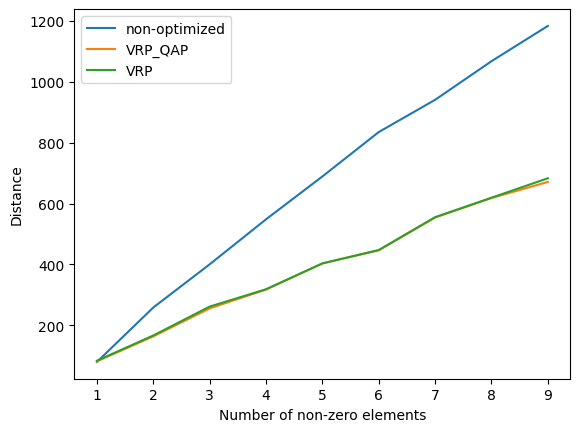

In [26]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='non-optimized')
plt.plot(stat[:,0],stat[:,2],label='VRP_QAP')
plt.plot(stat[:,0],stat[:,3],label='VRP')
plt.legend()
plt.xlabel('Number of non-zero elements')
plt.ylabel('Distance')
plt.show()

In [27]:
# perform linear regression and calculate the slope
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
for i in range(1,4):
    X = stat[:,0].reshape(-1,1)
    y = stat[:,i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    # print the slope   
    print('Slope:', model.coef_[0])

# plot the result

Slope: 137.8333333333333
Slope: 73.49999999999997
Slope: 74.21428571428568


In [21]:
stat[:,2]/stat[:,1]

array([0.67857143, 0.57692308, 0.59661836, 0.60984183, 0.58998647,
       0.56263736, 0.57454891, 0.56984668, 0.54531835, 0.55363091,
       0.53892944, 0.53795014, 0.53099174, 0.53371869, 0.53542234,
       0.54024968, 0.53594507, 0.53143078, 0.53466077])

In [28]:
def matrix_to_sequence(matrix,optimization_iteration=5):

    experiments = random_choose_candidate(96,24,i)
    jobs = np.argwhere(experiments)
    distance_matrix = calculate_distance_matrix(jobs,experiments.shape[0],experiments.shape[1])
    optimized_distance, P, new_jobs, recorder= CVRP_QAP(experiments,iteration=5)
    show_matrix(P)
    non_optimized_distance = distance_calculator(jobs)

    return non_optimized_distance, optimized_distance

In [29]:
column_permutation = np.eye(96)
# Function to swap two columns in a matrix
def swap_columns(matrix, col1, col2):
    matrix[:, [col1, col2]] = matrix[:, [col2, col1]]
# record the optimized distance and non-optimized distance in each permutation
update_a = a
stat = []
non_optimized_distance, optimized_distance = matrix_to_sequence(update_a)
stat.append((0,non_optimized_distance,optimized_distance))
# pick an integer from 0 to 10 with gaussian distribution
for i in range(100):
    num_permutation = np.random.normal(5, 2)
    num_permutation = int(num_permutation)
    # randomly swipe two columns n times
    for j in range(num_permutation):
        exchange_columns = np.random.choice(96, 2, replace=False)
        swap_columns(column_permutation, exchange_columns[0], exchange_columns[1])
    update_a = np.dot(a, column_permutation)
    show_matrix(update_a)
    non_optimized_distance, optimized_distance = matrix_to_sequence(update_a)
    stat.append((i+1,non_optimized_distance,optimized_distance))
stat = np.array(stat)

NameError: name 'a' is not defined

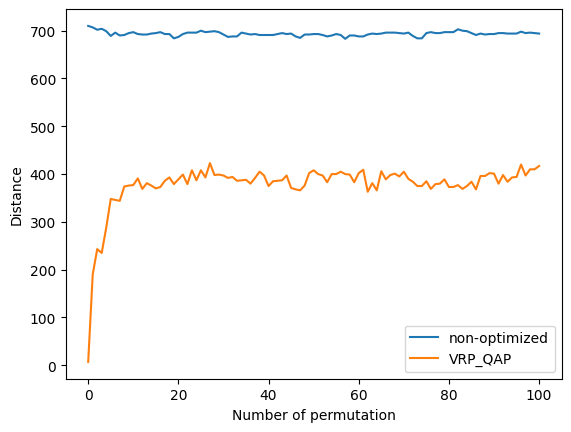

In [14]:
# plot the result
plt.plot(stat[:,0],stat[:,1],label='non-optimized')
plt.plot(stat[:,0],stat[:,2],label='VRP_QAP')
plt.legend()
plt.xlabel('Number of permutation')
plt.ylabel('Distance')
plt.show()
